In [15]:
# import os
# import json
# import glob
# import copy

# import numpy as np
# import pylab as pl
# import seaborn as sns
# import pandas as pd
# import cPickle as pkl

# from scipy import stats as spstats

# from pipeline.python.classifications import experiment_classes as util
# from pipeline.python.utils import natural_keys, label_figure
# from pipeline.python.classifications import aggregate_data_stats as aggr
# from pipeline.python.retinotopy import fit_2d_rfs as fitrf
# from pipeline.python.classifications import evaluate_receptivefield_fits as evalrfs
# from pipeline.python.classifications import retino_structure as ret

# import itertools
# import statsmodels as sm

import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import convert_coords as cc

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.utils import natural_keys, label_figure, convert_range

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
from pipeline.python.classifications import retino_structure as retstruct
from pipeline.python.classifications import rf_utils as rfutils


In [16]:
%matplotlib notebook

In [17]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Set dataset params

In [21]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)


... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [22]:

#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])


filter_by = 'drop_repeats'
data_id = '%s|%s' % (data_id, filter_by)
print(data_id)


traces001|fit-2dgaus_dff-no-cutoff-thr-0.50|drop_repeats


# Select datasets

In [19]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)


# Load dataframes

In [66]:
reload(rfutils)
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [98]:
scale_sigma = True
reliable_only = True

#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  reliable_only=reliable_only,
                                                  #scale_sigma=scale_sigma, 
                                                  fov_type=fov_type, state=state, stimulus='rfs')

#### Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs' if visual_area=='V1' else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    if expname not in g['experiment'].values:
        vdf = g[g['experiment']==altname]
    else:
        vdf = g[g['experiment']==expname]
    rdf_list.append(vdf)
df = pd.concat(rdf_list)

#### Filter for good fits only
df = df[df['r2']>fit_thr]
df.groupby(['visual_area']).count()
    
#### Split fx, fy for theta comp
fx = abs(df[['std_x', 'std_y']].max(axis=1) * np.cos(df['theta']))
fy = abs(df[['std_x', 'std_y']].max(axis=1) * np.sin(df['theta']))

df['fx'] = fx
df['fy'] = fy


droppin repeats
Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4


In [100]:
df.groupby(['visual_area', 'datakey', 'experiment']).count()


r2  fwhm_x  fwhm_y  theta   x0  \
visual_area datakey             experiment                                    
Li          20190502_JC076_fov1 rfs          19      19      19     19   19   
            20190522_JC089_fov1 rfs10         6       6       6      6    6   
            20190527_JC092_fov2 rfs10        14      14      14     14   14   
            20190527_JC092_fov3 rfs10        42      42      42     42   42   
            20190528_JC092_fov1 rfs10         7       7       7      7    7   
            20190605_JC090_fov1 rfs10        17      17      17     17   17   
            20190607_JC091_fov1 rfs10        69      69      69     69   69   
            20190612_JC099_fov1 rfs10        40      40      40     40   40   
            20190614_JC091_fov1 rfs10        99      99      99     99   99   
            20190617_JC099_fov1 rfs10        11      11      11     11   11   
            20191003_JC111_fov1 rfs10        11      11      11     11   11   
            20191007_JC091_fov1 rfs10        21      21      21     21   21   
            20191008_JC091_fov1 rfs10        46      46      46     46   46   
            20191018_JC113_fov1 rfs10        13      13      13     13   13   
            20191105_JC117_fov1 rfs10        10      10      10     10   10   
            20191111_JC120_fov1 rfs10         4       4       4      4    4   
Lm          20190423_JC076_fov1 rfs          15      15      15     15   15   
            20190509_JC078_fov1 rfs          15      15      15     15   15   
            20190513_JC078_fov1 rfs          19      19      19     19   19   
            20190517_JC083_fov1 rfs          23      23      23     23   23   
            20190525_JC084_fov1 rfs          38      38      38     38   38   
            20190602_JC080_fov2 rfs10        34      34      34     34   34   
            20190603_JC080_fov1 rfs          57      57      57     57   57   
            20190618_JC097_fov1 rfs10        28      28      28     28   28   
            20190627_JC091_fov1 rfs           9       9       9      9    9   
            20191004_JC110_fov3 rfs10        11      11      11     11   11   
            20191004_JC110_fov4 rfs10        19      19      19     19   19   
            20191012_JC113_fov3 rfs10        18      18      18     18   18   
            20191104_JC117_fov2 rfs10        50      50      50     50   50   
            20191106_JC120_fov4 rfs10         8       8       8      8    8   
            20191111_JC117_fov2 rfs10         2       2       2      2    2   
V1          20190420_JC076_fov1 rfs          36      36      36     36   36   
            20190511_JC083_fov1 rfs          44      44      44     44   44   
            20190522_JC084_fov1 rfs         130     130     130    130  130   
            20190613_JC097_fov1 rfs          67      67      67     67   67   
            20190616_JC097_fov1 rfs         102     102     102    102  102   
            20190617_JC097_fov1 rfs          89      89      89     89   89   
            20190622_JC085_fov1 rfs          27      27      27     27   27   
            20191006_JC110_fov1 rfs          48      48      48     48   48   
            20191106_JC120_fov3 rfs10        66      66      66     66   66   
            20191111_JC117_fov1 rfs10        21      21      21     21   21   

                                             y0  animalid  cell  fovnum  \
visual_area datakey             experiment                                
Li          20190502_JC076_fov1 rfs          19        19    19      19   
            20190522_JC089_fov1 rfs10         6         6     6       6   
            20190527_JC092_fov2 rfs10        14        14    14      14   
            20190527_JC092_fov3 rfs10        42        42    42      42   
            20190528_JC092_fov1 rfs10         7         7     7       7   
            20190605_JC090_fov1 rfs10        17        17    17      17   
            20190607_JC091_fov1 rfs10        69

## How many cells w/ RF fits per area and per dataset?

In [101]:
counts_by_fov = df.groupby(['visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()

<IPython.core.display.Javascript object>


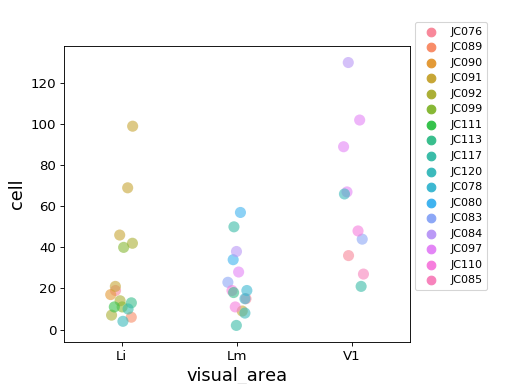

,animalid,datakey,cell
visual_area,,,
Li,16,16,16
Lm,15,15,15
V1,10,10,10


In [102]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='cell', data=counts_by_fov, ax=ax,
             hue='animalid', size=10, alpha=0.6)
ax.legend(bbox_to_anchor=(1, 1.1))
pl.subplots_adjust(right=0.8)

counts_by_fov.groupby(['visual_area']).count()

In [103]:
full_stimuli = []
for (visual_area, animalid, session, fovnum), g in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    sd = sdata[(sdata['visual_area']==visual_area) 
                  & (sdata['animalid']==animalid) 
                  & (sdata['session']==session) 
                  & (sdata['fovnum']==fovnum)]
    
    if 'gratings' in sd['experiment'].values and 'blobs' in sd['experiment'].values:
        full_stimuli.append(g['datakey'].unique()[0])
        
counts_by_fov_full = df[df['datakey'].isin(full_stimuli)].groupby(['visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
counts_by_fov_full.groupby(['visual_area']).count()


,animalid,datakey,cell
visual_area,,,
Li,9,9,9
Lm,6,6,6
V1,7,7,7


In [105]:
df[df['datakey'].isin(full_stimuli)].groupby(['visual_area', 'datakey']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  \
visual_area datakey                                                     
Li          20190605_JC090_fov1   17      17      17     17   17   17   
            20190607_JC091_fov1   69      69      69     69   69   69   
            20190612_JC099_fov1   40      40      40     40   40   40   
            20190614_JC091_fov1   99      99      99     99   99   99   
            20190617_JC099_fov1   11      11      11     11   11   11   
            20191008_JC091_fov1   46      46      46     46   46   46   
            20191018_JC113_fov1   13      13      13     13   13   13   
            20191105_JC117_fov1   10      10      10     10   10   10   
            20191111_JC120_fov1    4       4       4      4    4    4   
Lm          20190513_JC078_fov1   19      19      19     19   19   19   
            20190517_JC083_fov1   23      23      23     23   23   23   
            20190525_JC084_fov1   38      38      38     38   38   38   
            20190603_JC080_fov1   57      57      57     57   57   57   
            20190618_JC097_fov1   28      28      28     28   28   28   
            20190627_JC091_fov1    9       9       9      9    9    9   
V1          20190511_JC083_fov1   44      44      44     44   44   44   
            20190522_JC084_fov1  130     130     130    130  130  130   
            20190613_JC097_fov1   67      67      67     67   67   67   
            20190616_JC097_fov1  102     102     102    102  102  102   
            20190617_JC097_fov1   89      89      89     89   89   89   
            20190622_JC085_fov1   27      27      27     27   27   27   
            20191006_JC110_fov1   48      48      48     48   48   48   

                                 animalid  cell  experiment  fovnum  session  \
visual_area datakey                                                            
Li          20190605_JC090_fov1        17    17          17      17       17   
            20190607_JC091_fov1        69    69          69      69       69   
            20190612_JC099_fov1        40    40          40      40       40   
            20190614_JC091_fov1        99    99          99      99       99   
            20190617_JC099_fov1        11    11          11      11       11   
            20191008_JC091_fov1        46    46          46      46       46   
            20191018_JC113_fov1        13    13          13      13       13   
            20191105_JC117_fov1        10    10          10      10       10   
            20191111_JC120_fov1         4     4           4       4        4   
Lm          20190513_JC078_fov1        19    19          19      19       19   
            20190517_JC083_fov1        23    23          23      23       23   
            20190525_JC084_fov1        38    38          38      38       38   
            20190603_JC080_fov1        57    57          57      57       57   
            20190618_JC097_fov1        28    28          28      28       28   
            20190627_JC091_fov1         9     9           9       9        9   
V1          20190511_JC083_fov1        44    44          44      44       44   
            20190522_JC084_fov1       130   130         130     130      130   
            20190613_JC097_fov1        67    67          67      67       67   
            20190616_JC097_fov1       102   102         102     102      102   
            20190617_JC097_fov1        89    89          89      89       89   
            20190622_JC085_fov1        27    27          27      27       27   
            20191006_JC110_fov1        48    48          48      48       48   

                                 std_x  std_y  fwhm_avg  std_avg  area  \
visual_area datakey                                                      
Li          20190605_JC090_fov1     17     17        17       17    17   
            20190607_JC091_fov1     69     69        69       69    69   
            20190612_JC099_fov1     40     40        40       40

# Get RF evaluation results

In [54]:
animalid = 'JC091'
session = '20190614'
fovnum=1
exp='rfs10'
glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 'combined_%s_*' % exp,
                                 'traces', '%s*' % traceid, 'receptive_fields', fit_desc,
                                 'evaluation', 'regr_results_deviants*.json'))

['/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_601a1c_traces001_e2ec1e_traces001_473e42_traces001_72c645_traces001_2a113f/receptive_fields/fit-2dgaus_dff-no-cutoff/evaluation/regr_results_deviants_bycond.json']

In [56]:
no_eval = []
for (visual_area, animalid, session, fovnum, exp), g in df.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'experiment']):
    rfname = 'gratings' if int(session)<20190511 else exp
    devpath = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                     'combined_%s_*' % rfname, 
                                 'traces', '%s*' % traceid, 'receptive_fields', fit_desc, 
                                 'evaluation', 'regr_results_deviants*.json')) #'good_bad_weird_*.json'))
    if len(devpath) == 0:
        #print(g)
        no_eval.append(g['datakey'].unique()[0])
print("Re-run bootstrap evaluation on %i datasets" % len(no_eval))
if len(no_eval) > 0:
    for f in no_eval:
        print(f)

Re-run bootstrap evaluation on 0 datasets


In [107]:
filter_by

'drop_repeats'

# Create output dir for analysis


In [435]:
fit_desc = fitrf.get_fit_desc(response_type=response_type)
print fit_desc

outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)

scatter_dir = os.path.join(outdir, 'scatter', 'deviants')
if not os.path.exists(scatter_dir):
    os.makedirs(scatter_dir)
    
print(scatter_dir)


fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/deviants


In [110]:
#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

## Check wtih 1 animal

In [111]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


rootdir = '/n/coxfs01/2p-data'
devpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*', 
                                 'traces', '%s*' % traceid, 'receptive_fields', fit_desc, 
                                 'evaluation', 'regr_results_deviants*.json'))[0]
with open(devpath, 'r') as f:
    regresults = json.load(f)


In [116]:
regresults['elevation']['deviants']

[11,
 18,
 26,
 33,
 41,
 43,
 51,
 57,
 70,
 77,
 106,
 112,
 115,
 119,
 135,
 140,
 151,
 155,
 179,
 215,
 216,
 236,
 237,
 243,
 244,
 249,
 252,
 255,
 258]

In [118]:
dev_both = np.intersect1d(regresults['azimuth']['deviants'], regresults['elevation']['deviants'])
#print('%i deviants found' % len(dev_both))

[i for i in dev_both if i not in regresults['reliable_rois']]

[]

# Get dataset info

In [413]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [466]:
filter_by='drop_repeats'

min_nrois = 5
dsets = aggr.get_metadata(stimulus='rfs', traceid=traceid, fov_type=fov_type, state=state, filter_by=filter_by,
                         stimulus_only=True)
print(dsets[['visual_area', 'animalid']].drop_duplicates().groupby(['visual_area']).count())

d_list = []
no_results=[]
for (visual_area, animalid, session, fovnum, exp), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'experiment']):
    datakey = '_'.join([animalid, session, 'fov%i' % fovnum, exp])
    try:
        rfname = 'gratings' if int(session) < 20190511 else exp
        devpath = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                         'combined_%s_*' % rfname, 
                                         'traces', '%s*' % traceid, 'receptive_fields', fit_desc, 
                                         'evaluation', 'regr_results_deviants*.json'))[0]
    except Exception as e:
        no_results.append(datakey)
        continue
        
    with open(devpath, 'r') as f:
        regresults = json.load(f)
            
    n_reliable = len(regresults['reliable_rois']) 
    if n_reliable < min_nrois:
        print('... skipping [%s] %s (%i reliable)' % (visual_area, datakey, n_reliable))
        continue
        
    for cond in ['azimuth', 'elevation']:
        curr_devs = regresults[cond]['deviants']
        frac_dev = float(len(curr_devs)) / float(n_reliable)
        
        tmpd = pd.DataFrame({'rid': curr_devs,
                             'n_pass': [len(regresults[cond]['pass_rois']) for _ in np.arange(0, len(curr_devs))],
                             'n_reliable': [n_reliable for _ in np.arange(0, len(curr_devs))],
                             'fraction_deviant': [frac_dev for _ in np.arange(0, len(curr_devs))],
                              'condition': [cond for _ in np.arange(0, len(curr_devs))],
                              'animalid': [animalid for _ in np.arange(0, len(curr_devs))],
                              'session': [session for _ in np.arange(0,  len(curr_devs))],
                              'fovnum': [fovnum for _ in np.arange(0, len(curr_devs))],
                              'experiment': [exp for _ in np.arange(0, len(curr_devs))],
                              'datakey': ['_'.join([session, animalid, 'fov%i' % fovnum]) for _ in np.arange(0, len(curr_devs))],
                              'visual_area': [visual_area for _ in np.arange(0, len(curr_devs))]})
        d_list.append(tmpd)
devdf = pd.concat(d_list, axis=0).reset_index(drop=True)

if len(no_results) > 0:
    print("Found %i datasets without evaluations:" % len(no_results))
    for d in no_results:
        print(d)

droppin repeats
Excluding 24 total repeats
Selecting 42 dsets
             animalid
visual_area          
Li                 11
Lm                 11
V1                  8
... skipping [Li] JC080_20190602_fov1_rfs10 (1 reliable)
... skipping [Li] JC089_20190522_fov1_rfs (3 reliable)
... skipping [Li] JC120_20191111_fov1_rfs10 (4 reliable)
... skipping [Lm] JC117_20191111_fov2_rfs10 (2 reliable)


# Get count stats for deviant data

In [467]:
cols = [i for i in devdf.columns if i!='rid']
counts = devdf[cols].copy().drop_duplicates()
print(counts.shape)

(82, 10)


In [468]:
commoncounts = pd.concat([g for v, g in counts.groupby(['visual_area', 'datakey']) \
           if ('rfs' in g['experiment'].values) and ('rfs10' in g['experiment'].values)], axis=0)

print(commoncounts.shape)
commoncounts[['visual_area', 'experiment', 'datakey']].drop_duplicates().groupby(['visual_area', 'datakey']).count()

(24, 10)


experiment
visual_area datakey                        
Li          20191007_JC091_fov1           2
Lm          20190618_JC097_fov1           2
V1          20190613_JC097_fov1           2
            20190616_JC097_fov1           2
            20190622_JC085_fov1           2
            20191006_JC110_fov1           2

## Are there more/less deviant cells if tested wtih RFs vs RFs10?

#### Fraction deviant, by experiment type (rfs/rfs) and condition (azimuth, elevation)

<IPython.core.display.Javascript object>


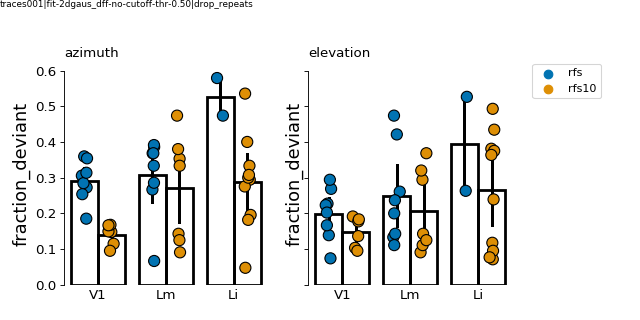

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/deviants', 'frac_deviants_RF-v-RF10__dfilter-drop_repeats_')


In [470]:
use_common_fovs=False

_df = commoncounts.copy() if use_common_fovs else counts.copy()
compare_str = 'common-dsets' if use_common_fovs else ''


color1='w'; color2='k';
palette = 'colorblind'

fig, axes = pl.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)

for ai, (ax, (cond, plotdf)) in enumerate(zip(axes.flat, _df.groupby(['condition']))):

    sns.barplot("visual_area", "fraction_deviant", data=plotdf, 
                ax=ax, order=visual_areas, hue='experiment',
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)

    sns.stripplot(x='visual_area', y='fraction_deviant', data=plotdf, 
                  ax=ax, hue='experiment',
                  s=10, palette=palette, order=visual_areas, 
                  #color='w', 
                  dodge=True,
                  marker='o', edgecolor='k', linewidth=1)
                      
    #ax.set_ylim([-0.05, 0.601])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    #ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(cond, loc='left', fontsize=12)
    
    if ai==0:
        ax.legend_.remove()
        
handles, labels = ax.get_legend_handles_labels()
l = pl.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)

pl.subplots_adjust(left=0.1, right=0.8, top=0.8)
label_figure(fig, data_id)


figname = 'frac_deviants_RF-v-RF10__dfilter-%s_%s' % (str(filter_by), compare_str)
pl.savefig(os.path.join(scatter_dir, '%s.svg' % figname))
print(scatter_dir, figname)

In [ ]:
#stats?

#### If deviant for azimuth, also deviant for elevation?

<IPython.core.display.Javascript object>


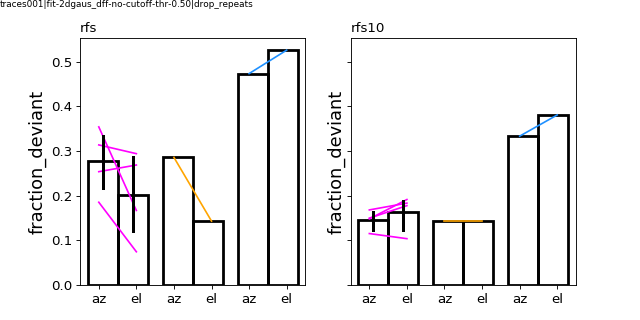

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/deviants', 'frac_deviants_pairwise_az-v-el_rfs-v-rfs10__dfilter-drop_repeats_common-dsets')


In [472]:
use_common_fovs=True


_df = commoncounts.copy() if use_common_fovs else counts.copy()
compare_str = 'common-dsets' if use_common_fovs else ''


offset = 0.25
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(0)

marker= 'o'
for ax, (experiment, currdf) in zip(axes.flat, _df.groupby(['experiment'])):
    aix = 0
    #currdf = fraction_dev[fraction_dev['experiment']==experiment]
    for ai, visual_area in enumerate(visual_areas):
        
        plotdf = currdf[currdf['visual_area']==visual_area]
        az_vals = plotdf[plotdf['condition']=='azimuth'].sort_values(by='datakey')['fraction_deviant'].values
        el_vals = plotdf[plotdf['condition']=='elevation'].sort_values(by='datakey')['fraction_deviant'].values

        by_dset = [(a, e) for a, e in zip(az_vals, el_vals)]
        for p in by_dset:
            ax.plot([aix-offset, aix+offset], p, marker=None, color=area_colors[visual_area], alpha=1)

        aix = aix+1
    ax.set_title(experiment, loc='left', fontsize=12)

    
for ai, (ax, (cond, plotdf)) in enumerate(zip(axes.flat, _df.groupby(['experiment']))):

    sns.barplot("visual_area", "fraction_deviant", data=plotdf, 
                hue='condition',
                ax=ax, order=visual_areas,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)
    ax.legend_.remove()
    
    ax.set_xticks([0-offset, 0+offset, 1-offset, 1+offset, 2-offset, 2+offset])
    ax.set_xticklabels(['az', 'el', 'az', 'el', 'az', 'el'])
    
    ax.set_xlabel('')
    
    
label_figure(fig, data_id)
figname = 'frac_deviants_pairwise_az-v-el_rfs-v-rfs10__dfilter-%s_%s' % (str(filter_by), compare_str) 
pl.savefig(os.path.join(scatter_dir, '%s.svg' % figname))
print(scatter_dir, figname)

# Reliability of fits, compare experiment type

<IPython.core.display.Javascript object>


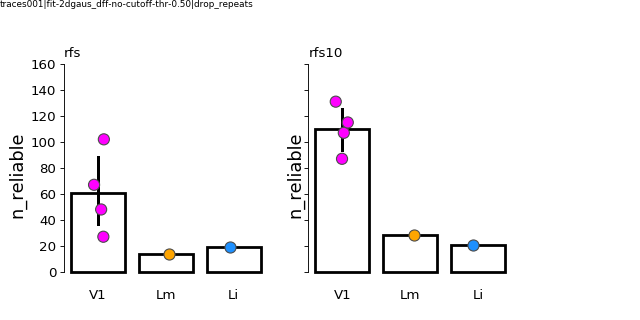

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/deviants', 'n_reliable_rfs-v-rfs10__dfilter-drop_repeats_common-dsets')


In [476]:
metric = 'n_reliable'
use_common_fovs=True

_df = commoncounts.copy() if use_common_fovs else counts.copy()
compare_str = 'common-dsets' if use_common_fovs else ''


fig, axes = pl.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)

currdf = _df[_df['condition']=='azimuth'] # only need 1 cond

for ai, (ax, (cond, plotdf)) in enumerate(zip(axes.flat, currdf.groupby(['experiment']))):
    sns.barplot(x="visual_area", y=metric, data=plotdf, 
                ax=ax, order=visual_areas,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)
    
    sns.stripplot(x='visual_area', y=metric, data=plotdf, 
                  ax=ax, #hue='cond',
                  s=10, palette=area_colors, order=visual_areas, 
                  #color='w', 
                  dodge=True,
                  #edgecolor=area_colors,
                  marker='o',linewidth=1)
    
     
    ax.set_ylim([-10, 160])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    #ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(cond, loc='left', fontsize=12)
    

pl.subplots_adjust(left=0.1, right=0.8, top=0.8)

label_figure(fig, data_id)
figname = '%s_rfs-v-rfs10__dfilter-%s_%s' % (metric, str(filter_by), compare_str) 
pl.savefig(os.path.join(scatter_dir, '%s.svg' % figname))
print(scatter_dir, figname)

In [325]:
currdf = counts[(counts['experiment']=='rfs10')]
results = aggr.do_mannwhitney(currdf, metric='n_pass')
results

[('V1', 'Lm')] Statistics=24.000, p=0.034, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=38.000, p=0.002, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=66.000, p=0.465, ... Same distribution (fail to reject H0)


[(('V1', 'Lm'), False, 0.067093053682888343),
 (('V1', 'Li'), True, 0.0072153053860461794),
 (('Lm', 'Li'), False, 0.46504929437757214)]

In [326]:
currdf = counts[(counts['experiment']=='rfs')]
results = aggr.do_mannwhitney(currdf, metric='n_pass')
results

[('V1', 'Lm')] Statistics=16.000, p=0.000, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=0.000, p=0.016, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=12.000, p=0.463, ... Same distribution (fail to reject H0)


[(('V1', 'Lm'), True, 0.00075333897301133469),
 (('V1', 'Li'), True, 0.031067395393953642),
 (('Lm', 'Li'), False, 0.46335000935542364)]

# ---------------------------------------------------------------------------------------------------
# Get rest of RF data - drop duplicates
# ---------------------------------------------------------------------------------------------------


In [477]:
scale_sigma = True
reliable_only = True
filter_by = 'drop_repeats'

#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  reliable_only=reliable_only,
                                                  #scale_sigma=scale_sigma, 
                                                  fov_type=fov_type, state=state, stimulus='rfs')

#### Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs' if visual_area=='V1' else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    if expname not in g['experiment'].values:
        vdf = g[g['experiment']==altname]
    else:
        vdf = g[g['experiment']==expname]
    rdf_list.append(vdf)
df = pd.concat(rdf_list)
print(df.shape)

#### Filter for good fits only
df = df[df['r2']>fit_thr]
print(df.shape)

df.groupby(['visual_area']).count()


droppin repeats
Excluding 24 total repeats
Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4
(1405, 19)
(1405, 19)


,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,std_x,std_y,fwhm_avg,std_avg,area,datakey_ix
visual_area,,,,,,,,,,,,,,,,,,
Li,429,429,429,429,429,429,429,429,429,429,429,429,429,429,429,429,429,429
Lm,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346,346
V1,630,630,630,630,630,630,630,630,630,630,630,630,630,630,630,630,630,630


In [478]:
df.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,visual_area,std_x,std_y,fwhm_avg,std_avg,area,datakey_ix
0,0.826039,23.640365,13.125770,0.117896,6.700889,-8.282818,JC076,0,20190502_JC076_fov1,rfs,1,20190502,Li,10.059730,5.585434,18.383068,7.822582,176.519678,0
1,0.725070,43.796452,29.207447,0.234407,-22.165338,-2.970096,JC076,84,20190502_JC076_fov1,rfs,1,20190502,Li,18.636788,12.428701,36.501949,15.532744,727.690433,0
2,0.701576,47.503138,24.790225,0.458457,15.301437,31.251545,JC076,115,20190502_JC076_fov1,rfs,1,20190502,Li,20.214101,10.549032,36.146682,15.381567,669.910720,0
3,0.781400,23.130716,44.809417,0.155088,2.496442,37.699467,JC076,120,20190502_JC076_fov1,rfs,1,20190502,Li,9.842858,19.067837,33.970067,14.455348,589.620427,0
4,0.627347,32.132070,25.065036,5.892774,0.014677,17.244112,JC076,135,20190502_JC076_fov1,rfs,1,20190502,Li,13.673221,10.665973,28.598553,12.169597,458.164233,0


## Get deviant data for included dsets

In [479]:
min_nrois = 5


d_list = []
no_results=[]
for (visual_area, animalid, session, fovnum, exp), g in df.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'experiment']):
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    
    try:
        rfname = 'gratings' if int(session) < 20190511 else exp
        devpath = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                         'combined_%s_*' % rfname, 
                                         'traces', '%s*' % traceid, 'receptive_fields', fit_desc, 
                                         'evaluation', 'regr_results_deviants*.json'))[0]
    except Exception as e:
        no_results.append((datakey, exp))
        continue
        
    with open(devpath, 'r') as f:
        regresults = json.load(f)
            
    n_reliable = len(regresults['reliable_rois']) 
    if n_reliable < min_nrois:
        print('... skipping [%s] %s (%i reliable)' % (visual_area, datakey, n_reliable))
        continue


    for cond in ['azimuth', 'elevation']:
        curr_devs = regresults[cond]['deviants']
        frac_dev = float(len(curr_devs)) / float(n_reliable)
        if len(curr_devs)==0:
            print("[%s, %s] 0 of %i deviant" % (datakey, cond, n_reliable))
        
        tmpd = pd.DataFrame({'rid': curr_devs,
                             'n_pass': [len(regresults[cond]['pass_rois']) for _ in np.arange(0, len(curr_devs))],
                             'n_reliable': [n_reliable for _ in np.arange(0, len(curr_devs))],
                             'fraction_deviant': [frac_dev for _ in np.arange(0, len(curr_devs))],
                              'condition': [cond for _ in np.arange(0, len(curr_devs))],
                              'animalid': [animalid for _ in np.arange(0, len(curr_devs))],
                              'session': [session for _ in np.arange(0,  len(curr_devs))],
                              'fovnum': [fovnum for _ in np.arange(0, len(curr_devs))],
                              'experiment': [exp for _ in np.arange(0, len(curr_devs))],
                              'datakey': ['_'.join([session, animalid, 'fov%i' % fovnum]) for _ in np.arange(0, len(curr_devs))],
                              'visual_area': [visual_area for _ in np.arange(0, len(curr_devs))]})
        d_list.append(tmpd)
devdf = pd.concat(d_list, axis=0).reset_index(drop=True)

if len(no_results) > 0:
    print("Found %i datasets without evaluations:" % len(no_results))
    for d in no_results:
        print(d)

[20190522_JC089_fov1, azimuth] 0 of 6 deviant
[20190522_JC089_fov1, elevation] 0 of 6 deviant
[20190527_JC092_fov2, azimuth] 0 of 14 deviant
[20190528_JC092_fov1, azimuth] 0 of 7 deviant
[20190528_JC092_fov1, elevation] 0 of 7 deviant
[20191003_JC111_fov1, azimuth] 0 of 11 deviant
[20191003_JC111_fov1, elevation] 0 of 11 deviant
[20191105_JC117_fov1, elevation] 0 of 10 deviant
... skipping [Li] 20191111_JC120_fov1 (4 reliable)
... skipping [Lm] 20191111_JC117_fov2 (2 reliable)


In [480]:
cols = [i for i in devdf.columns if i!='rid']
counts = devdf[cols].copy().drop_duplicates()

## Combine RF properties + deviant info

In [481]:
df_filt = []
for (datakey, exp), g in df.groupby(['datakey', 'experiment']):
    incl_rois = g['cell'].values

    d_ = devdf[(devdf['datakey']==datakey) & (devdf['experiment']==exp)].copy()
    if d_.shape[0]==0:
        print('- No deviants (%s, %s)' % (datakey, exp))
        dev_rois = []
    else:
        dev_rois = d_['rid'].values    
        n_rel = float(d_['n_reliable'].unique())
        assert n_rel == len(incl_rois), "[%s, %s] %i reliable (doesn't match filtered df, %i)" % (datakey, exp, n_rel, len(incl_rois))

    if len(incl_rois) < min_rois:
        continue

    g['deviant'] = [1 if rid in dev_rois else 0 for rid in incl_rois]
    df_filt.append(g)
    #df['deviant'][g.index] = [1 if rid in dev_rois else 0 for rid in incl_rois]
    
    
ddf = pd.concat(df_filt, axis=0).reset_index(drop=True)

- No deviants (20190522_JC089_fov1, rfs10)
- No deviants (20190528_JC092_fov1, rfs10)
- No deviants (20191003_JC111_fov1, rfs10)
- No deviants (20191111_JC117_fov2, rfs10)
- No deviants (20191111_JC120_fov1, rfs10)


## Calculate fraction deviant

In [482]:
fracdevs = ddf[['visual_area', 'animalid', 'session', 'fovnum', 'datakey', 'deviant']].groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']).mean().reset_index()
fracdevs.head()

,visual_area,animalid,session,fovnum,datakey,deviant
0,Li,JC076,20190502,1,20190502_JC076_fov1,0.631579
1,Li,JC089,20190522,1,20190522_JC089_fov1,0.000000
2,Li,JC090,20190605,1,20190605_JC090_fov1,0.352941
3,Li,JC091,20190607,1,20190607_JC091_fov1,0.579710
4,Li,JC091,20190614,1,20190614_JC091_fov1,0.666667


<IPython.core.display.Javascript object>


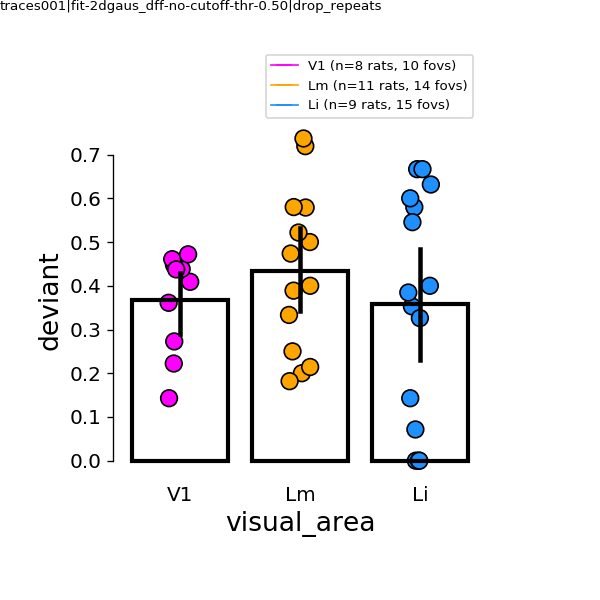

********* deviant **********
[('V1', 'Lm')] Statistics=54.000, p=0.182, ... Same distribution (fail to reject H0)
[('V1', 'Li')] Statistics=74.500, p=0.500, ... Same distribution (fail to reject H0)
[('Lm', 'Li')] Statistics=89.500, p=0.256, ... Same distribution (fail to reject H0)
[(('V1', 'Lm'), False, 0.54614464404790675), (('V1', 'Li'), False, 0.54614464404790675), (('Lm', 'Li'), False, 0.54614464404790675)]
0.96
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/deviants', 'deviant__dfilter-drop_repeats')


In [506]:
curr_metric = 'deviant'
multi_comp_test = 'holm'
mean_metric = 'mean'

fig, ax = pl.subplots(figsize=(5,5), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.barplot(x="visual_area", y=curr_metric, data=fracdevs, 
            ax=ax, order=visual_areas, ci=95,
            errcolor="k", edgecolor=('k', 'k', 'k'), 
            facecolor=(1,1,1,0), linewidth=2.5)

sns.stripplot(x='visual_area', y=curr_metric, data=fracdevs, 
              zorder=0,
              ax=ax, #hue='cond',
              s=10, palette=area_colors, 
              order=visual_areas, 
              color=(1,1,1,0), 
              dodge=True,
              #facecolor=(1,1,1,0),
              edgecolor='k',
              marker='o',linewidth=1)

print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(fracdevs, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax)
print("****************************")

#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True)
ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(fracdevs, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)



label_figure(fig, data_id)
figname = '%s__dfilter-%s' % (curr_metric, str(filter_by)) 
pl.savefig(os.path.join(scatter_dir, '%s.svg' % figname))
print(scatter_dir, figname)

# General stats

In [493]:
curr_metric = 'std'
params = ['x0', 'y0', 'theta', 
          '%s_x' % curr_metric, '%s_y' % curr_metric, '%s_avg' % curr_metric] #, 'fx', 'fy', 'visual_area']
print(params)

['x0', 'y0', 'theta', 'std_x', 'std_y', 'std_avg']


In [491]:
ddf.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,visual_area,std_x,std_y,fwhm_avg,std_avg,area,datakey_ix,deviant
0,0.562528,28.572930,15.422330,3.627706,46.971460,5.644719,JC076,5,20190420_JC076_fov1,rfs,1,20190420,V1,12.158694,6.562694,21.997630,9.360694,250.679559,0,1
1,0.623552,28.575655,16.920918,0.332517,33.631338,0.145126,JC076,7,20190420_JC076_fov1,rfs,1,20190420,V1,12.159853,7.200391,22.748286,9.680122,275.064323,0,1
2,0.571907,26.208758,14.696606,0.118463,40.044793,3.620414,JC076,24,20190420_JC076_fov1,rfs,1,20190420,V1,11.152663,6.253875,20.452682,8.703269,219.117785,0,0
3,0.764697,33.891185,21.968508,0.518928,43.848785,3.223044,JC076,25,20190420_JC076_fov1,rfs,1,20190420,V1,14.421781,9.348301,27.929846,11.885041,423.546855,0,1
4,0.703703,27.526040,18.687675,0.236946,43.578727,3.081931,JC076,26,20190420_JC076_fov1,rfs,1,20190420,V1,11.713209,7.952202,23.106858,9.832705,292.626170,0,0


#### Are deviants deviant in features besides position?

<IPython.core.display.Javascript object>


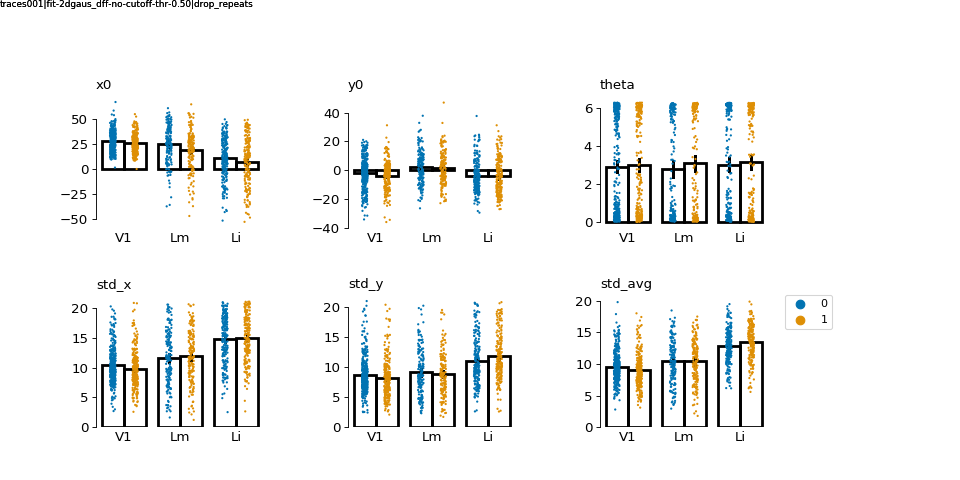

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/deviants', 'all_params_split_cells_deviant__dfilter-drop_repeats')


In [507]:
#metric = 'r2'

color1='w'
color2='k'
palette = 'colorblind'


fig, axn = pl.subplots(2,3, figsize=(12,6)) #igsize=(8,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axn.flat, params)):
    sns.stripplot(x='visual_area', y=param, data=ddf, 
                  ax=ax, hue='deviant',
                  s=2, palette=palette, order=visual_areas, 
                  #color='w', 
                  dodge=True,
                  marker='o', edgecolor='none', linewidth=1)

    sns.barplot("visual_area", param, data=ddf, 
                ax=ax, order=visual_areas, hue='deviant',
                errcolor="k", edgecolor=('k', 'k', 'k'),  zorder=1,
                facecolor=(1,1,1,0), linewidth=2.5)
    
    if ai!=(len(params)-1):
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        l = pl.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)

    ax.set_xlabel('')
    ax.tick_params(which='both', axis='x', length=0)
    ax.patch.set_alpha(0)
    ax.set_title(param, loc='left', fontsize=12)
    ax.set_ylabel('')
    
#ax.set_ylim([-0.05, 0.601])
sns.despine(bottom=True, trim=True)

pl.subplots_adjust(left=0.1, right=0.8, top=0.8, wspace=0.5, hspace=0.5)
label_figure(fig, data_id)

label_figure(fig, data_id)
figname = 'all_params_split_cells_deviant__dfilter-%s' % str(filter_by)
pl.savefig(os.path.join(scatter_dir, '%s.svg' % figname))
print(scatter_dir, figname)

## Average rfs and rfs10

In [33]:
min_nrois = 5
average_rfs = False
i=0
avg_dev=[]

for (v, dk, cond), g in devdf.groupby(['visual_area', 'datakey', 'cond']):

    rfname = 'rfs10' if 'rfs10' in g['experiment'].unique() else 'rfs'
    if g[g['experiment']==rfname]['n_rois_pass'].unique()[0] < min_nrois \
    or g[g['experiment']==rfname]['deviants'].unique()[0]==None:
        #print(dk)
        continue

    #frac_dev = g[g['rfname']==rfname].shape[0] / g[g['rfname']==rfname]['n_rois_pass'].unique()[0]

    if 'rfs' in g['experiment'].unique() and 'rfs10' in g['experiment'].unique():
        rfs10_nrois = g[g['experiment']=='rfs10']['n_rois_pass'].unique()[0]
        rfs_nrois = g[g['experiment']=='rfs']['n_rois_pass'].unique()[0]

        frac_dev1 = float(len(g[g['experiment']=='rfs10']['deviants'].unique())) / rfs10_nrois
        frac_dev2 = float(len(g[g['experiment']=='rfs']['deviants'].unique())) / rfs_nrois

        frac_dev = np.mean([frac_dev1, frac_dev2])
        nrois_pass = np.mean([rfs10_nrois, rfs_nrois])
    else:
        frac_dev = float(len(g['deviants'].unique())) / g['n_rois_pass'].unique()[0]
        nrois_pass = g['n_rois_pass'].unique()[0]
        
    avg_dev.append(pd.DataFrame({'visual_area': v,
                                 'datakey': dk,
                                 'cond': cond,
                                 'fraction_deviant': frac_dev,
                                 'n_rois_pass': nrois_pass}, index=[i]))
    i+=1

avg_dev = pd.concat(avg_dev, axis=0).reset_index(drop=True)
    


In [34]:
avg_dev[avg_dev['fraction_deviant']==avg_dev['fraction_deviant'].min()]


,cond,datakey,fraction_deviant,n_rois_pass,visual_area
76,azimuth,20191004_JC110_fov2,0.051282,117.0,V1


In [35]:
avg_dev[avg_dev['datakey']=='20191004_JC110_fov2']

,cond,datakey,fraction_deviant,n_rois_pass,visual_area
76,azimuth,20191004_JC110_fov2,0.051282,117.0,V1
77,elevation,20191004_JC110_fov2,0.128205,117.0,V1


In [36]:
devdf[devdf['datakey']=='20191004_JC110_fov2']

,cond,datakey,deviants,experiment,n_rois,n_rois_pass,visual_area
1194,elevation,20191004_JC110_fov2,27,rfs10,118,117,V1
1195,elevation,20191004_JC110_fov2,35,rfs10,118,117,V1
1196,elevation,20191004_JC110_fov2,42,rfs10,118,117,V1
1197,elevation,20191004_JC110_fov2,52,rfs10,118,117,V1
1198,elevation,20191004_JC110_fov2,56,rfs10,118,117,V1
1199,elevation,20191004_JC110_fov2,71,rfs10,118,117,V1
1200,elevation,20191004_JC110_fov2,90,rfs10,118,117,V1
1201,elevation,20191004_JC110_fov2,97,rfs10,118,117,V1
1202,elevation,20191004_JC110_fov2,129,rfs10,118,117,V1
1203,elevation,20191004_JC110_fov2,174,rfs10,118,117,V1


In [37]:
sdata[sdata['animalid']=='JC110']


NameError: name 'sdata' is not defined

In [39]:
avg_dev.head()

,cond,datakey,fraction_deviant,n_rois_pass,visual_area
0,azimuth,20190502_JC076_fov1,0.555556,18.0,Li
1,elevation,20190502_JC076_fov1,0.166667,18.0,Li
2,azimuth,20190522_JC089_fov1,0.611111,5.0,Li
3,elevation,20190522_JC089_fov1,0.611111,5.0,Li
4,azimuth,20190527_JC092_fov2,0.117647,17.0,Li


<IPython.core.display.Javascript object>


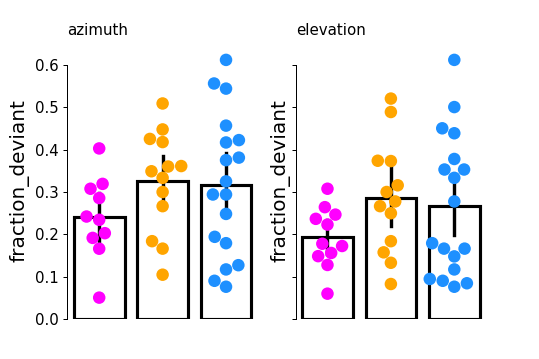

In [38]:

fig, axes = pl.subplots(1, 2, figsize=(6,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)

for ax, (cond, plotdf) in zip(axes.flat, avg_dev.groupby(['cond'])):
    sns.barplot("visual_area", "fraction_deviant", data=plotdf, ax=ax, order=visual_areas,
                     errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    sns.swarmplot(x='visual_area', y='fraction_deviant', data=plotdf, ax=ax, 
                  palette=area_colors, s=10, marker='o', order=visual_areas) #palette=area_colors)

    #ax.set_ylim([-0.05, 0.601])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(cond, loc='left', fontsize=12)

In [198]:
c1 = fraction_dev[fraction_dev['visual_area']=='V1']['fraction_deviant'].values
c2 = fraction_dev[fraction_dev['visual_area']=='Lm']['fraction_deviant'].values
c3 = fraction_dev[fraction_dev['visual_area']=='Li']['fraction_deviant'].values

# Shapiro-Wilk normality test 
print(spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

# Levene variance test  
print(spstats.levene(c1, c2, c3))


F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

import statsmodels.stats.multicomp as ml

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

((0.9737732410430908, 0.6466492414474487), (0.9297449588775635, 0.09621530771255493), (0.8193102478981018, 2.516557742637815e-06))
LeveneResult(statistic=3.3774655438715868, pvalue=0.038032346784845045)
F statistic = 1.290 and probability p = 0.280
(104,)
(104,)
(104,)
(104,)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm   -0.0287  -0.1307 0.0734 False 
  Li     V1   -0.0639  -0.1588 0.031  False 
  Lm     V1   -0.0352  -0.1478 0.0773 False 
--------------------------------------------


<IPython.core.display.Javascript object>


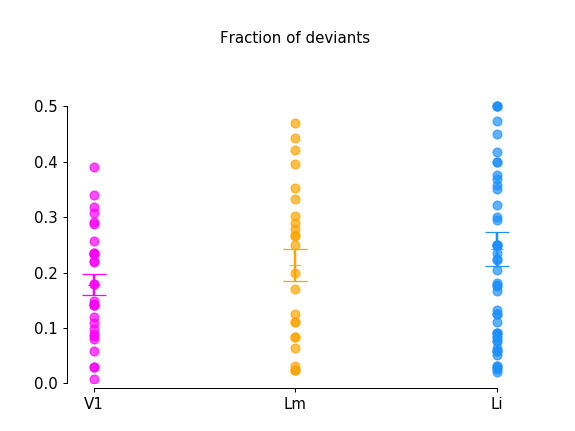

Text(0.5,1,u'Fraction of deviants')

In [173]:
fig, ax = pl.subplots()
vi = 0
for visual_area in visual_areas:
    g = fraction_dev[fraction_dev['visual_area']==visual_area]
    values = g['fraction_deviant'].values
    ax.scatter([vi for _ in range(len(values))], values,  marker='o', alpha=0.7, s=50,
               color=area_colors[visual_area])
              #edgecolor=area_colors[visual_area], facecolor='none')
        
    ax.plot(vi, values.mean(), marker='_', color=area_colors[visual_area], linewidth=2, markersize=10, alpha=0.8)
    ax.errorbar(vi, values.mean(), yerr=spstats.sem(values), ecolor=area_colors[visual_area], capsize=10, lw=2)
    #sns.boxplot(x=[vi for _ in range(len(values))], y=values, color=area_colors[visual_area])
    vi += 1
ax.set_ylim([0, .6])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(visual_areas)
sns.despine(ax=ax, trim=True, offset=4)

ax.set_title("Fraction of deviants")

#pl.savefig(os.path.join(outdir, 'fraction_deviants.svg'))

In [202]:
fig, axes = pl.subplots(1, 2, figsize=(6,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)


for ax, (rfname, g) in zip(axes.flat, fraction_dev.groupby(['rfname'])):
    sns.barplot(x="visual_area", y="fraction_deviant", data=g, 
                ax=ax, order=visual_areas, col='cond',
                     errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    sns.swarmplot(x='visual_area', y='fraction_deviant', data=g, ax=ax, 
                  palette=area_colors, s=10, marker='o', order=visual_areas) #palette=area_colors)

    #ax.set_ylim([-0.05, 0.601])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(rfname, loc='left', fontsize=12)


<IPython.core.display.Javascript object>

AttributeError: Unknown property col

In [201]:
fraction_dev[fraction_dev['rfname']=='rfs10']


,visual_area,datakey,cond,rfname,n_rois,n_rois_pass,fraction_deviant
4,Li,20190522_JC089_fov1,azimuth,rfs10,11,9,0.222222
5,Li,20190522_JC089_fov1,elevation,rfs10,11,9,0.111111
6,Li,20190527_JC092_fov2,azimuth,rfs10,17,17,0.058824
7,Li,20190527_JC092_fov2,elevation,rfs10,17,17,0.058824
8,Li,20190527_JC092_fov3,azimuth,rfs10,48,47,0.063830
9,Li,20190527_JC092_fov3,elevation,rfs10,48,47,0.021277
10,Li,20190528_JC092_fov1,azimuth,rfs10,8,8,0.125000
11,Li,20190528_JC092_fov1,elevation,rfs10,8,8,0.125000
14,Li,20190602_JC091_fov1,azimuth,rfs10,90,84,0.250000
15,Li,20190602_JC091_fov1,elevation,rfs10,90,84,0.357143


In [175]:
fraction_dev.head()

,visual_area,datakey,rfname,n_rois,n_rois_pass,fraction_deviant
0,Li,20190502_JC076_fov1,rfs,21,18,0.500000
1,Li,20190502_JC076_fov1,rfs,21,18,0.166667
2,Li,20190522_JC089_fov1,rfs,3,1,1.000000
3,Li,20190522_JC089_fov1,rfs,3,1,1.000000
4,Li,20190522_JC089_fov1,rfs10,11,9,0.222222


In [ ]:
fig, axes = pl.subplots(1, 2, figsize=(6,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)


for ax, (rfname, g) in zip(axes.flat, fraction_dev.groupby(['rfname'])):
    sns.barplot("visual_area", "fraction_deviant", data=g, ax=ax, order=visual_areas,
                     errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)


    sns.swarmplot(x='visual_area', y='fraction_deviant', data=g, ax=ax, 
                  palette=area_colors, s=10, marker='o', order=visual_areas) #palette=area_colors)

    ax.set_ylim([-0.05, 0.601])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(rfname, loc='left', fontsize=12)


In [16]:
def get_rfdata(sdata, fit_desc=None, excluded_sessions=[]):
    assert fit_desc is not None, "No fit-desc specified!"
    
    rfdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
    for skey in excluded_sessions:
        animalid, session = skey.split('-')
        drop_ixs = rfdata[(rfdata['animalid']==animalid) & (rfdata['session']==session)].index.tolist()
        rfdata= rfdata.drop(drop_ixs)
            
    fit_these = []
    dpaths = {}
    unknown = []
    for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']): #animalid in rfdata['animalid'].unique():
        skey = '-'.join([animalid, session])
        if skey in excluded_sessions:
            continue

        rfruns = g['experiment'].unique()

        for rfname in rfruns:
            if int(session) < 20190511:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_gratings*', 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            else:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_%s_*' % rfname, 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            if len(fpath) > 0:
                assert len(fpath)==1, "TOo many paths: %s" % str(fpath)
                dpaths['-'.join([animalid, session, fov, rfname])] = fpath[0]
                
            elif len(fpath) == 0:
                fit_these.append((animalid, session, fov, rfname))
            else:
                unknown.append((animalid, session, fov, rfname))
#     nostats = []
#     for (animalid, session, fov, run_name) in fit_these:
#         nostats = resp.visualize_session_stats(animalid, session, fov, altdir=aggregate_session_dir, create_new=True)

    print ("N dpaths: %i, N unfit: %i, N unknown: %i" % (len(dpaths), len(fit_these), len(unknown)))
    print("--- these needs fits: ---")
    for fd in fit_these:
        print(fd)
    print("N datasets included: %i, N sessions excluded: %i" % (rfdata.shape[0], len(excluded_sessions)))
    #assert (len(dpaths) + len(fit_these) + len(unknown)) == rfdata.shape[0] - len(excluded_sessions), "There are dsets unaccounted for..."
    
    rfdata = rfdata.reset_index()
    fillpaths = ['' for _ in range(rfdata.shape[0])]
    for skey, fpath in dpaths.items():
        animalid, session, fov, rfname = skey.split('-')
        df_ix = rfdata[ (rfdata['animalid']==animalid) \
                           & (rfdata['session']==session) \
                           & (rfdata['fov']==fov) \
                           & (rfdata['experiment']==rfname)].index.tolist()[0]
        fillpaths[df_ix] = fpath
        
    rfdata['path'] = fillpaths
    
    return rfdata #, nostats

In [17]:
rfdata = get_rfdata(dsets, fit_desc=fit_desc, excluded_sessions=excluded_sessions)

ValueError: need more than 1 value to unpack

In [39]:
rfdata.head()

,index,animalid,experiment,fov,session,visual_area,fovnum,path
0,136,JC078,rfs,FOV1_zoom2p0x,20190513,Lm,1,/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0...
1,143,JC080,rfs,FOV1_zoom2p0x,20190603,Lm,1,/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0...
2,160,JC083,rfs,FOV1_zoom2p0x,20190511,V1,1,/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0...
3,164,JC083,rfs,FOV1_zoom2p0x,20190512,Lm,1,/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0...
4,168,JC083,rfs,FOV1_zoom2p0x,20190517,Lm,1,/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0...


In [40]:
rfdata.iloc[0]['path']

'/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/fit_results.pkl'

In [18]:

def regplot(x, y, data=None, x_estimator=None, x_bins=None, x_ci="ci",
            scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None,
            order=1, logistic=False, lowess=False, robust=False,
            logx=False, x_partial=None, y_partial=None,
            truncate=False, dropna=True, x_jitter=None, y_jitter=None,
            label=None, color=None, marker="o",
            scatter_kws=None, line_kws=None, ax=None):

    plotter = sns.regression._RegressionPlotter(x, y, data, x_estimator, x_bins, x_ci,
                                 scatter, fit_reg, ci, n_boot, units,
                                 order, logistic, lowess, robust, logx,
                                 x_partial, y_partial, truncate, dropna,
                                 x_jitter, y_jitter, color, label)

    if ax is None:
        ax = pl.gca()

    scatter_kws = {} if scatter_kws is None else copy.copy(scatter_kws)
    scatter_kws["marker"] = marker
    line_kws = {} if line_kws is None else copy.copy(line_kws)
    plotter.plot(ax, scatter_kws, line_kws)
    return ax, plotter




def do_regr_on_fov(bootdata, bootcis, posdf, cond='azimuth', ci=.95, xaxis_lim=None):
    
    fig, ax = pl.subplots(figsize=(10,8))
    
    ax.set_title(cond)
    ax.set_ylabel('RF position (rel. deg.)')
    ax.set_xlabel('FOV position (um)')
    if xaxis_lim is not None:
        ax.set_xlim([0, xaxis_lim])
    
    axname = 'xpos' if cond=='azimuth' else 'ypos'
    parname = 'x0' if cond=='azimuth' else 'y0'
    
    # Get lis of cells that pass boot
    roi_list = [k for k, g in bootdata.groupby(['cell'])]  
    
    # Identify which cells fail...
    fail_rois = [r for r in posdf.index.tolist() if r not in roi_list]
    fadedf = posdf.loc[fail_rois]
    sns.regplot('%s_fov' % axname, '%s_rf' % axname, data=fadedf, color='k', marker='x', fit_reg=False,
                scatter_kws=dict(s=10, alpha=0.1), ax=ax, label='no fit')

    # Plot successes and regression with CI
    ax, plotter = regplot('%s_fov' % axname, '%s_rf' % axname, data=posdf.loc[roi_list], ci=ci*100, 
                          color='k', marker='o',
                scatter_kws=dict(s=8, alpha=.7), ax=ax, label='measured (regr: %i%% CI)' % int(ci*100) )

    # Get CIs from regression fit to "good data"
    grid, yhat, err_bands = plotter.fit_regression(grid=plotter.x)
    e1 = err_bands[0, :] # err_bands[0, np.argsort(xvals)] <- sort by xpos to plot
    e2 = err_bands[1, :] #err_bands[1, np.argsort(xvals)]
    regr_cis = np.array([(ex, ey) for ex, ey in zip(e1, e2)])
    
    # Get rois sorted by position:
    x0_meds = np.array([g[parname].mean() for k, g in bootdata.groupby(['cell'])])
    x0_lower = bootcis['%s_lower' % parname][roi_list]
    x0_upper = bootcis['%s_upper' % parname][roi_list]

    ci_intervals = bootcis['x0_upper'] - bootcis['x0_lower']
    weird = [i for i in ci_intervals.index.tolist() if ci_intervals[i] > 10]
    print(len(weird))
    rlist = [i for i in roi_list if i not in weird]
    roi_ixs = np.array([roi_list.index(i) for i in rlist])
    roi_list = np.array([i for i in roi_list if i not in weird])
    #print(regr_cis[roi_ixs])

    xvals = posdf['%s_fov' % axname][roi_list].values
    yvals = posdf['%s_rf' % axname][roi_list].values
    
    # Plot bootstrap results    
    ax.scatter(xvals, x0_meds[roi_ixs], c='k', marker='_', alpha=0.7, 
               label='bootstrapped (%i%% CI)' % int(ci*100) )
    ax.errorbar(xvals, x0_meds[roi_ixs], yerr=np.array(zip(x0_meds[roi_ixs]-x0_lower.iloc[roi_ixs], x0_upper.iloc[roi_ixs]-x0_meds[roi_ixs])).T, 
            fmt='none', color='k', alpha=0.7, lw=1)
    
    if xaxis_lim is not None:
        ax.set_xticks(np.arange(0, xaxis_lim, 100))
        
    #ax.set_ylim([-10, 40])
    sns.despine(offset=4, trim=True, ax=ax)
    ax.legend()

    # Check that values make sense
    deviants = []
    bad_fits = []
    for roi,lo,up,(regL, regU), med in zip(roi_list, x0_lower.iloc[roi_ixs], x0_upper.iloc[roi_ixs], regr_cis[roi_ixs], yvals):
        if (lo <= med <= up):
            if ((regL > lo and regL > up) or (regU < lo and regU < up)):
                #print(lo, med, up)
                xv = posdf['%s_fov' % axname][roi]
                yv = posdf['%s_rf' % axname][roi]
                ax.plot(xv, yv, marker='o', markersize=5, color='magenta', alpha=0.8)
                ax.plot(xv, yv, marker='x', markersize=5, color='magenta', alpha=1.0)
                deviants.append(roi)
        else:
            # Measured not within CIs
            bad_fits.append(roi)
   
    return fig, regr_cis, deviants, bad_fits


# Plot 1 fov

In [ ]:
        exp = util.ReceptiveFields(rfname, animalid, session, fov,
                                   traceid=traceid) #, trace_type='dff')
        statsdir, stats_desc = util.create_stats_dir(exp.animalid, exp.session, exp.fov,
                                                      traceid=exp.traceid, trace_type=exp.trace_type,
                                                      response_type=response_type, 
                                                      responsive_test=None, responsive_thr=0)

        if not os.path.exists(os.path.join(statsdir, 'receptive_fields')):
            os.makedirs(os.path.join(statsdir, 'receptive_fields'))
        print("Saving stats output to: %s" % statsdir)    


        #%%
        # Get output dir for stats
        try:
            estats = exp.get_stats(response_type=response_type, fit_thr=fit_thr) # estats.rois = list of all cells that pass fit-thr
        except Exception as e:
            d_errors.append(datakey)
            continue
            
        rfdf = estats.fits
        fovinfo = estats.fovinfo
        rois_rfs = rfdf.index.tolist()

        # Get RF dir for current fit type         
        rfdir, fit_desc = fitrf.create_rf_dir(exp.animalid, exp.session, exp.fov, exp.name, traceid=exp.traceid,
                                        response_type=response_type, fit_thr=fit_thr)

        data_identifier = '|'.join([animalid, session, fov, traceid, exp.rois, exp.trace_type, fit_desc])

        # Get bootstrap results for evaluated RFs
        bootresults = evalrfs.evaluate_rfs(estats, rfdir=rfdir, 
                                           n_bootstrap_iters=n_iters, n_resamples=n_resamples,
                                           ci=ci, sigma_scale=sigma_scale)

<IPython.core.display.Javascript object>


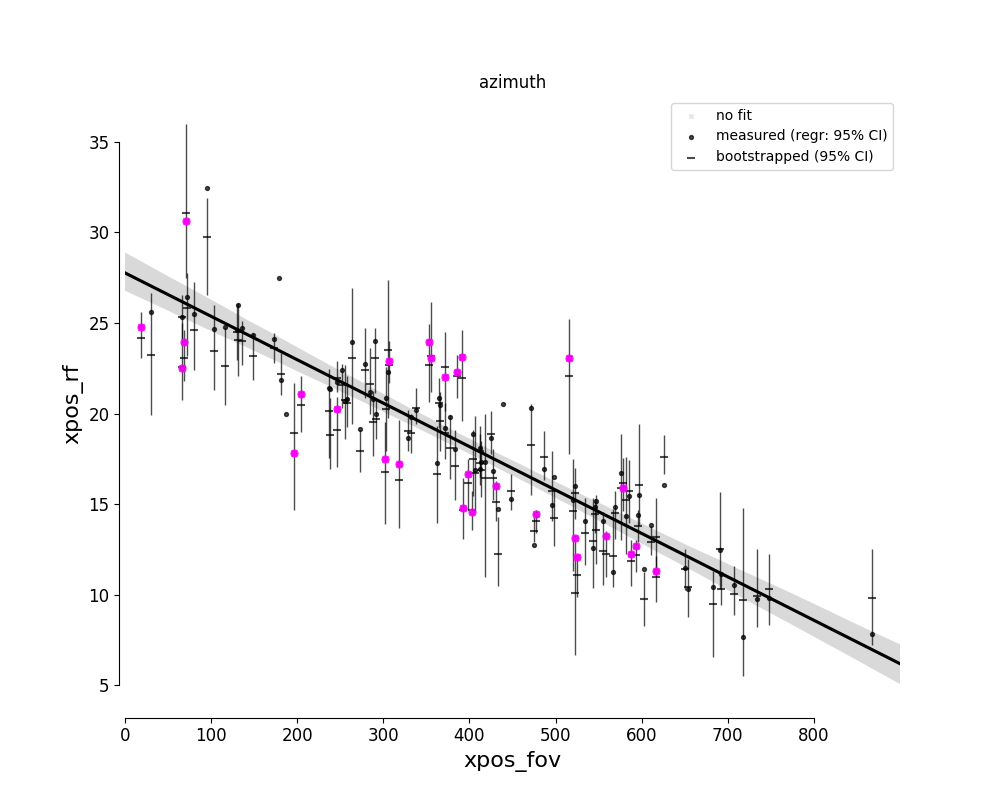

3


In [158]:
#### Calculate scatter

bootdata = bootresults['data']
bootcis = bootresults['cis']

x0_lower = bootcis['%s_lower' % parname][roi_list]
x0_upper = bootcis['%s_upper' % parname][roi_list]
for 
bootcis['x0_upper'] - bootcis['x0_lower']
    
posdf = fovinfo['positions']
xlim, ylim = fovinfo['xlim'], fovinfo['ylim']

#% # Plot bootstrapped param CIs + regression CI
xaxis_lim = max([xlim, ylim])
regresults={}


cond = 'azimuth'
fig, regr_cis, deviants, bad_fits = do_regr_on_fov(bootdata, bootcis, posdf, cond=cond, xaxis_lim=900)


In [159]:
outliers


[0,
 5,
 12,
 21,
 25,
 36,
 43,
 69,
 70,
 78,
 91,
 93,
 97,
 101,
 112,
 134,
 142,
 147,
 148,
 150,
 155,
 165,
 166,
 168,
 194,
 205,
 216,
 234]

## Compare gratings

In [161]:
fovdir = os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum)
osi_niters = 1000
osi_nsamples = 20

osi_str = 'fit-dff_all-cells_boot-%i-resample-%i' % (osi_niters, osi_nsamples)
osi_dir = glob.glob(os.path.join(fovdir, 'combined_gratings_static', 'traces', '%s*' % traceid, 'tuning', osi_str))[0]

os.listdir(osi_dir)

osi_eval_dfile = os.path.join(osi_dir, 'tuning_bootstrap_evaluation.pkl')
assert os.path.exists(osi_eval_dfile), "No evaulation found! %s" % osi_dir
with open(osi_eval_dfile, 'rb') as f:
    osi_eval = pkl.load(f)


In [162]:
osi_thr = 0.6
osi_mean_iters = osi_eval['fits'].groupby(['cell']).mean()
osi_fits = osi_mean_iters[osi_mean_iters['gof']>=osi_thr]
rois_osi = osi_fits.index.tolist()
print(len(rois_osi))

82


In [164]:
matched_rois = [r for r in rois_osi if r in outliers]
matched_rois

[5, 12, 21, 25, 91, 93, 112, 142, 147, 148, 166, 205, 216]

In [ ]:
osis_with_rfs = [r for r in roi_osi if r in ]

In [166]:
len(matched_rois) / float(len(rois_osi))


0.15853658536585366

In [48]:
estats.fovinfo.keys()

['roi_contours', 'positions', 'zimg', 'ylim', 'xlim']

In [21]:
rfdata[rfdata['animalid']=='JC080']

,index,animalid,experiment,fov,session,visual_area,exp_no,animal_no,path
25,95,JC080,rfs,FOV1_zoom2p0x,20190603,Lm,3,2,/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0...
26,103,JC080,rfs10,FOV2_zoom2p0x,20190602,Lm,4,2,/n/coxfs01/2p-data/JC080/20190602/FOV2_zoom2p0...
27,105,JC080,rfs10,FOV1_zoom2p0x,20190602,Li,4,2,/n/coxfs01/2p-data/JC080/20190602/FOV1_zoom2p0...


In [22]:
missing_rfs = []
dlist = []
for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
    skey = '-'.join([visual_area, animalid, session, fov])
    #print skey
    devpath = os.path.join( os.path.split(g['path'].values[0])[0], 'evaluation', 'deviants.json')
    if not os.path.exists(devpath):
        missing_rfs.append(devpath)
        continue
    else:
        with open(devpath, 'r') as f:
            d = json.load(f)

    dev_list = [('azimuth', i) for i in d['azimuth']]
    dev_list.extend( [('elevation', i) for i in d['elevation']] )
    dev_list.extend([('pass', i) for i in d['pass_rois']])
    tmpd = pd.DataFrame({'condition': [c[0] for c in dev_list],
                         'cell': [c[1] for c in dev_list],
                         'visual_area': [visual_area for _ in range(len(dev_list))],
                         'animalid': [animalid for _ in range(len(dev_list))],
                         'session': [session for _ in range(len(dev_list))],
                         'fov': [fov for _ in range(len(dev_list))]})
    
    dlist.append(tmpd)
    

In [23]:
print(len(missing_rfs))

1


In [24]:
for f in missing_rfs:
    print f.split('/traces/')[0]

/n/coxfs01/2p-data/JC080/20190602/FOV1_zoom2p0x/combined_rfs10_static


In [25]:
print(len(dlist))

25


In [26]:
df = pd.concat(dlist, axis=0).reset_index(drop=True)


In [27]:
df.groupby(['visual_area', 'condition']).count()['cell']

visual_area  condition
Li           azimuth      120
             elevation     93
             pass         165
Lm           azimuth      144
             elevation    139
             pass         238
V1           azimuth      190
             elevation    167
             pass         611
Name: cell, dtype: int64

In [28]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [29]:
df['ratio'] = [0 for _ in range(df.shape[0])]

In [30]:
#ratios = dict((visual_area, {'azimuth': [], 'elevation': []}) for visual_area in visual_areas)
for condition in ['azimuth', 'elevation']:
    for k, g in df.groupby(['visual_area', 'animalid', 'session', 'fov']):
        npass = len(g[g['condition']=='pass'])
        nbad = len(g[g['condition']==condition])
        frac = float(nbad)/npass
        df.loc[g.index, 'ratio'] = [frac for _ in range(g.shape[0])]
        #g['fraction'] = [frac for _ in range(g.shape[0])]
        
        #ratios[k[0]][condition].append(float(nbad)/npass)
        
        

In [31]:
df

,animalid,cell,condition,fov,session,visual_area,ratio
0,JC076,7,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
1,JC076,11,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
2,JC076,120,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
3,JC076,135,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
4,JC076,176,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
5,JC076,177,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
6,JC076,179,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
7,JC076,181,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
8,JC076,187,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
9,JC076,196,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000


In [32]:
for k, g in df[df['visual_area']=='Li'].groupby(['animalid', 'session']):
    print k

('JC076', '20190502')
('JC090', '20190605')
('JC091', '20190602')
('JC091', '20190614')
('JC099', '20190609')
('JC099', '20190612')
('JC099', '20190617')


<IPython.core.display.Javascript object>


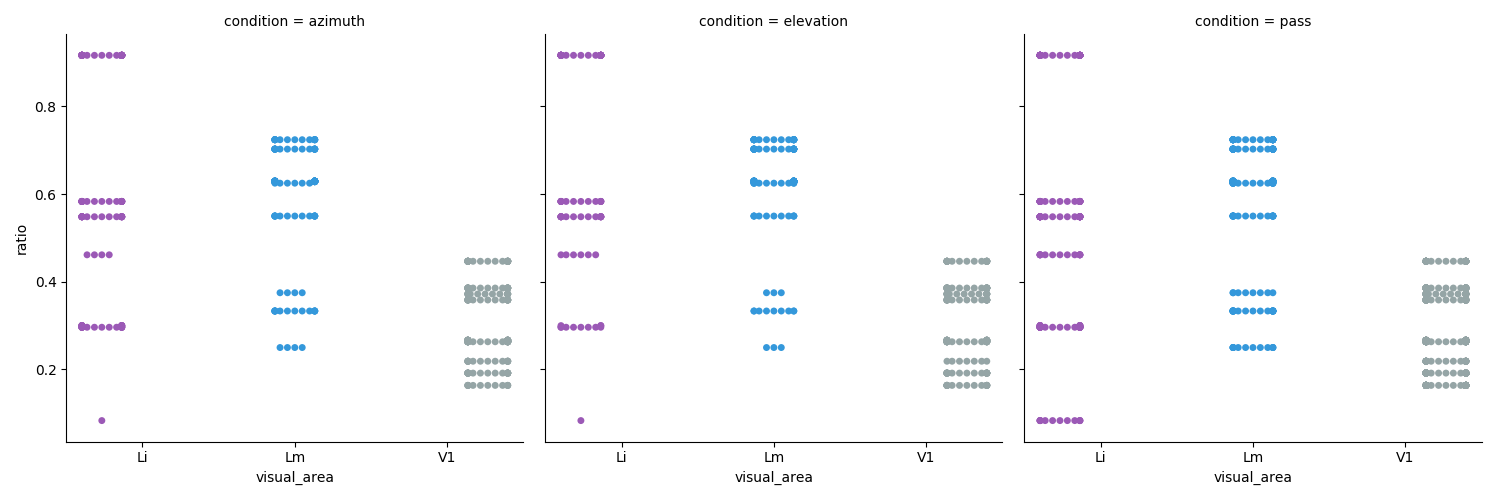

In [33]:
sns.catplot(x='visual_area', y='ratio', col='condition', hue='visual_area', data=df, \
            kind='swarm', dodge=True)

In [74]:
fracs_by_area = dict((visual_area, g.groupby(['animalid', 'session', 'fov'])['ratio'].unique().values.astype(float))\
                     for visual_area, g in df[df['condition']=='azimuth'].groupby(['visual_area']))
                     

In [75]:
df.head()

,animalid,cell,condition,fov,session,visual_area,ratio
0,JC076,7,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
1,JC076,11,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
2,JC076,120,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
3,JC076,135,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
4,JC076,176,azimuth,FOV1_zoom2p0x,20190502,Li,0.3


In [94]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/scatter'

<IPython.core.display.Javascript object>


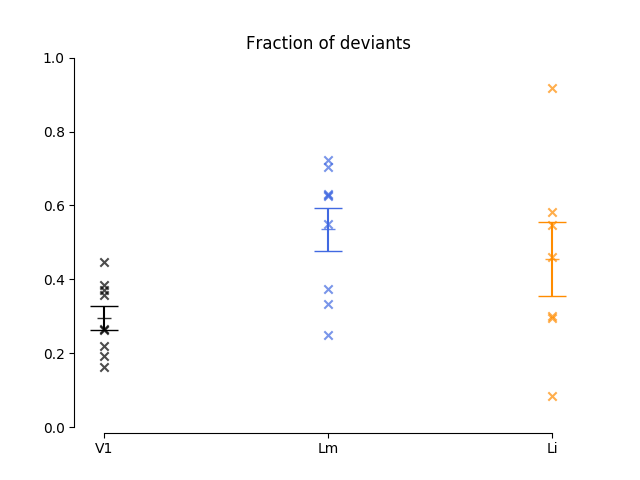

In [95]:
fig, ax = pl.subplots()

for vi, visual_area in enumerate(visual_areas):
    values = fracs_by_area[visual_area]
    ax.scatter([vi for _ in range(len(values))], values,  marker='x', color=area_colors[visual_area], alpha=0.7)
              #edgecolor=area_colors[visual_area], facecolor='none')
    ax.plot(vi, values.mean(), marker='_', color=area_colors[visual_area], markersize=10, alpha=0.8)
    ax.errorbar(vi, values.mean(), yerr=spstats.sem(values), ecolor=area_colors[visual_area], capsize=10)
    #sns.boxplot(x=[vi for _ in range(len(values))], y=values, color=area_colors[visual_area])
ax.set_ylim([0, 1])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(visual_areas)
sns.despine(ax=ax, trim=True, offset=4)

ax.set_title("Fraction of deviants")

pl.savefig(os.path.join(outdir, 'fraction_deviants.svg'))

In [40]:
g.groupby(['animalid', 'session', 'fov'])['ratio'].unique()

animalid  session   fov          
JC076     20190420  FOV1_zoom2p0x           [0.21875]
JC083     20190507  FOV1_zoom2p0x    [0.372093023256]
JC084     20190522  FOV1_zoom2p0x    [0.263157894737]
JC085     20190622  FOV1_zoom2p0x    [0.266666666667]
JC097     20190613  FOV1_zoom2p0x    [0.358490566038]
          20190615  FOV1_zoom2p0x    [0.191666666667]
                    FOV2_zoom2p0x    [0.163636363636]
          20190616  FOV1_zoom2p0x    [0.385714285714]
          20190617  FOV1_zoom2p0x    [0.446808510638]
Name: ratio, dtype: object

In [78]:
df.groupby(['visual_area', 'animalid', 'session', 'fov'])['ratio'].unique()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     [0.272727272727]
             JC090     20190605  FOV1_zoom2p0x    [0.0833333333333]
Lm           JC076     20190423  FOV1_zoom2p0x     [0.333333333333]
             JC078     20190426  FOV1_zoom2p0x      [0.62962962963]
                       20190430  FOV1_zoom2p0x     [0.724137931034]
                       20190513  FOV1_zoom2p0x     [0.733333333333]
             JC080     20190603  FOV1_zoom2p0x     [0.710526315789]
             JC083     20190508  FOV1_zoom2p0x     [0.611111111111]
             JC084     20190525  FOV1_zoom2p0x     [0.333333333333]
             JC091     20190627  FOV1_zoom2p0x              [0.375]
V1           JC076     20190420  FOV1_zoom2p0x     [0.266666666667]
             JC083     20190507  FOV1_zoom2p0x     [0.380952380952]
             JC084     20190522  FOV1_zoom2p0x     [0.272727272727]
             JC097     20190617  FOV1_zoom2p0x     [0.458333333333]
N